In [2]:
!pip install scikit-surprise

  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-win_amd64.whl size=747097 sha256=0a4334cd333b988050bcde68e2d77b1cbf85f1cf38eec7c6c46f57155f525066
  Stored in directory: c:\users\mahesh kumar m r\appdata\local\pip\cache\wheels\76\44\74\b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


### 1. Import libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from surprise import Reader, Dataset, SVD
from surprise.accuracy import rmse, mae
from surprise.model_selection import cross_validate

### 2. Importing Data

##### We are using dataset from movielens.org

In [4]:
data = pd.read_csv('ratings.csv')
data.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [6]:
data.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [11]:
data.shape

(100836, 4)

In [13]:
data.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [7]:
np.unique(data['userId'])

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [8]:
np.unique(data['movieId'])

array([     1,      2,      3, ..., 193585, 193587, 193609], dtype=int64)

In [9]:
np.unique(data['rating'])

array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])

### 2.1 Dropping timestamp column

In [14]:
data.drop(['timestamp'], axis = 1, inplace = True)

In [24]:
data.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


### 2.2 Check for missing data

In [25]:
data.isnull().sum()

userId     0
movieId    0
rating     0
dtype: int64

In [26]:
data.duplicated().sum()

0

### 3. Exploratory Data Analysis

### 3.1 Number of unique movies / users

In [28]:
u_movies = data['movieId'].nunique()
u_users = data['userId'].nunique()
print('Number of unique movies:', u_movies)
print('Number of unique users:', u_users)

Number of unique movies: 9724
Number of unique users: 610


### 3.2 Sparsity of Data

In [32]:
available_ratings = data['rating'].count()
print('Current number of ratings:', available_ratings)
total_ratings = u_movies * u_users
print('Total number of ratings:', total_ratings)
missing_ratings = total_ratings - available_ratings
print('Missing ratings:', missing_ratings)
sparsity = (missing_ratings / total_ratings) * 100
print('Sparsity:', sparsity)

Current number of ratings: 100836
Total number of ratings: 5931640
Missing ratings: 5830804
Sparsity: 98.30003169443864


### 3.3 Ratings Distribution

Text(0, 0.5, 'Frequency')

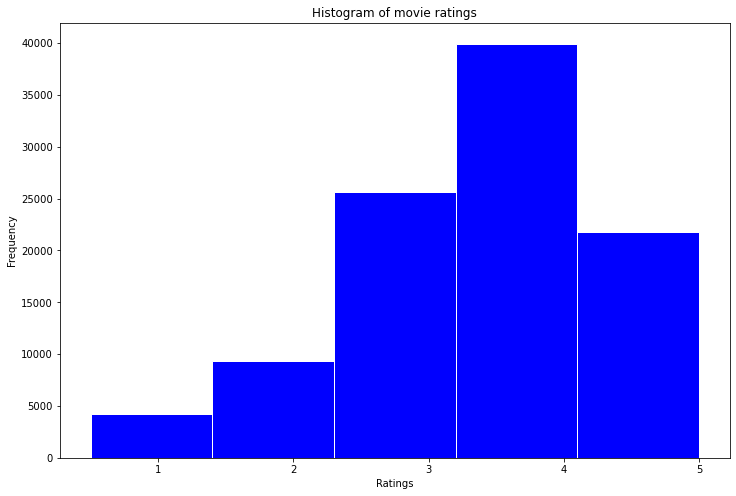

In [37]:
plt.figure(figsize = (12, 8))
plt.hist(data['rating'], color = 'blue',  edgecolor = 'white', bins = 5)
plt.title('Histogram of movie ratings')
plt.xlabel('Ratings')
plt.ylabel('Frequency')

### 4. Filtering movies / users

### 4.1 Filter movies with less than 3 ratings

In [46]:
filtered_movies = data['movieId'].value_counts() > 3
filtered_movies = filtered_movies[filtered_movies].index.tolist()

### 4.2 Filter users with less than 3 movies rated

In [47]:
filtered_users = data['userId'].value_counts() > 3
filtered_users = filtered_users[filtered_users].index.tolist()

In [49]:
new_data = data[(data['movieId'].isin(filtered_movies)) & (data['userId'].isin(filtered_users))]
print('original dataset shape:', data.shape)
print('New dataset shape:', new_data.shape)
new_data.head()

original dataset shape: (100836, 3)
New dataset shape: (92394, 3)


,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


### 5. Creating training and test set

In [65]:
# the default order for the surprise dataset is user - item (movieid) - rating
cols = ['userId', 'movieId', 'rating']

### 5.1 Create surprise dataset

In [66]:
reader = Reader(rating_scale = (0.5, 5))
data1 = Dataset.load_from_df(new_data[cols], reader)

### 5.2 Create train and test set

#### We are using complete data to train the model. Train set have pairs, userid and movieid which has ratings. Test set is called anti set. Anti set contains all the user-item pairs where the rating was missing in train set.

In [54]:
train = data1.build_full_trainset()
test = train.build_anti_testset()

### 6. Training the model using SVD

#### Singular Value Decomposition will take a sparse matrix, factorize into three matrices and multiply these three matrices to get complete interaction matrix

In [63]:
model = SVD(n_epochs = 50, verbose = True)

In [64]:
cross_validate(model, data1, measures = ['RMSE', 'MAE'], cv = 5, verbose = True)
print('Training Done')

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48
Processing epoch 49
Processing

### 7. Predictions

In [67]:
predictions = model.test(test)

#### iid means movied iid, r_ui means overall movie ratings, est means model predicted ratings and if was_impossible is false, model has generated rating for that user.

In [68]:
predictions[1]

Prediction(uid=1, iid=1704, r_ui=3.529119856267723, est=5, details={'was_impossible': False})

### Recommending top 3 movies to each user based on predictions

In [69]:
from collections import defaultdict
def get_top_n(predictions, n):
    #uid is key and user_ratings(iid, est) are values
    top_n = defaultdict(list)
    for uid, iid, _, est, _ in predictions:
        top_n[uid].append((iid, est))
        
    for uid, user_ratings in top_n.items():
        #x[0] - iid and x[1] - est
        user_ratings.sort(key = lambda x: x[1], reverse = True)
        top_n[uid] = user_ratings[:n]
    return top_n

top_n = get_top_n(predictions, n = 3)

for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, rating) in user_ratings])

1 [318, 1704, 74458]
2 [2324, 1784, 1104]
3 [33493, 4226, 1080]
4 [527, 1206, 2700]
5 [1283, 912, 1204]
6 [1291, 63082, 1172]
7 [34, 1203, 1250]
8 [1201, 3468, 5952]
9 [912, 1208, 260]
10 [3147, 2788, 3639]
11 [475, 3578, 2329]
12 [356, 553, 1197]
13 [1079, 1223, 7361]
14 [109374, 4226, 5690]
15 [608, 1041, 1208]
16 [4308, 44555, 1104]
17 [1223, 2202, 1274]
18 [1278, 5060, 916]
19 [7153, 951, 106920]
20 [527, 593, 910]
21 [106642, 2580, 3852]
22 [1276, 47, 1208]
23 [5995, 2360, 2329]
24 [912, 858, 1209]
25 [593, 1089, 1196]
26 [2571, 1210, 260]
27 [7153, 318, 457]
28 [4973, 1411, 1247]
29 [898, 2571, 1237]
30 [50, 356, 1136]
31 [2502, 497, 1276]
32 [1617, 750, 1204]
33 [112852, 260, 27773]
34 [750, 858, 2788]
35 [296, 356, 1219]
36 [7153, 858, 1197]
37 [50, 223, 930]
38 [46578, 3089, 4027]
39 [4973, 3160, 4848]
40 [527, 1089, 2959]
41 [25, 265, 1193]
42 [293, 1387, 1357]
43 [50, 70, 333]
44 [318, 356, 1213]
45 [58559, 5618, 8961]
46 [4306, 1261, 2959]
47 [750, 527, 919]
48 [318, 4973, 

#### Our recommender system recommended movies with id 318, 1704, 74458 to user_id 1 and so on for other users. So our recommender system suggested top 3 unseen movies to user based on the ratings of users by similar interest